In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pref_voting.utility_functions import *
from pref_voting.utility_profiles import UtilityProfile
from pref_voting.generate_spatial_profiles import generate_covariance
from pref_voting.generate_spatial_profiles import *

cand_cov = generate_covariance(2, 0.25, 1)
print(cand_cov)

cand_pos = (1, 1)
new_pos = np.random.multivariate_normal(cand_pos, cand_cov)

print(new_pos)

[[0.0625 0.0625]
 [0.0625 0.0625]]
[1.19385472 1.19385472]


In [2]:
sp = generate_spatial_profile(10, 5, 2)

up,virtual_cand_positions = sp.to_utility_profile(uncertainty_function=default_uncertainty_fn, batch=True, return_virtual_cand_positions=True)

NameError: name 'default_uncertainty_fn' is not defined

In [3]:
virtual_cand_positions

NameError: name 'virtual_cand_positions' is not defined

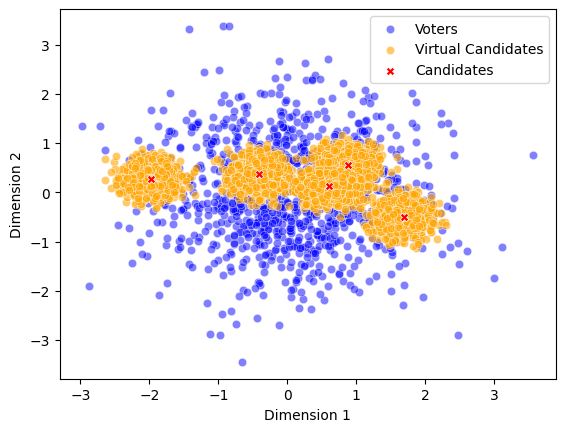

In [7]:

def default_uncertainty_fn(spatial_profile, cand, voter): 
    """
    The default uncertainty function for spatial profiles.  
    """
    return (0.2, 0)

sp = generate_spatial_profile(5, 1000, 2)
up,virtual_cand_positions = sp.to_utility_profile(uncertainty_function=default_uncertainty_fn, batch=True, return_virtual_cand_positions=True)
#sp.view()

sns.scatterplot(x=[sp.voter_position(v)[0] for v in sp.voters], 
                y=[sp.voter_position(v)[1] for v in sp.voters], 
                color="blue", 
                label="Voters", 
                alpha=0.5)

sns.scatterplot(
    x=[pos[0] for c in sp.candidates for pos in virtual_cand_positions[c]], 
    y=[pos[1] for c in sp.candidates for pos in virtual_cand_positions[c]], 
    color='orange', 
    alpha=0.6, 
    label="Virtual Candidates"
    )

scatter = sns.scatterplot(x=[sp.candidate_position(c)[0] for c in sp.candidates], 
                          y=[sp.candidate_position(c)[1] for c in sp.candidates], color="red", 
                          marker='X', 
                          label="Candidates")


# # Adding labels to each point
# for v in sp.voters:
#     plt.annotate(v + 1, (sp.voter_position(v)[0], sp.voter_position(v)[1]))
# for c in sp.candidates:
#     plt.annotate(c, (sp.candidate_position(c)[0], sp.candidate_position(c)[1]))

scatter.set(xlabel='Dimension 1', ylabel='Dimension 2')
plt.legend()
plt.savefig("spatial_profile_virtual_cands_5.pdf")
plt.show()


In [47]:
'' if True else (1, 2)

''

In [44]:
%timeit sp.to_utility_profile()

22.7 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
%timeit sp.to_utility_profile(uncertainty_function=default_uncertainty_fn)

264 ms ± 3.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
%timeit sp.to_utility_profile(uncertainty_function=default_uncertainty_fn, batch=True)

20 ms ± 209 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [60]:
class SpatialProfile(object): 
    """
    A spatial profile is a set of candidates and voters in a multi-dimensional space.  Each voter and candidate is assigned vector of floats representing their position on each issue.

    Args:
        cand_pos (dict): A dictionary mapping each candidate to their position in the space.
        voter_pos (dict): A dictionary mapping each voter to their position in the space.

    Attributes:
        candidates (list): A list of candidates.
        voters (list): A list of voters.    
        cand_pos (dict): A dictionary mapping each candidate to their position in the space.    
        voter_pos (dict): A dictionary mapping each voter to their position in the space.   
        num_dims (int): The number of dimensions in the space.  

    """
    def __init__(self, cand_pos, voter_pos):

        cand_dims = [len(v) for v in cand_pos.values()]
        voter_dims = [len(v) for v in voter_pos.values()]

        assert len(cand_dims) > 0, "There must be at least one candidate."
        assert len(set(cand_dims)) == 1, "All candidate positions must have the same number of dimensions."
        assert len(voter_dims) > 0, "There must be at least one voter."
        assert len(set(voter_dims)) == 1, "All voter positions must have the same number of dimensions."
        assert cand_dims[0] == voter_dims[0], "Candidate and voter positions must have the same number of dimensions."

        self.candidates = sorted(list(cand_pos.keys())) 
        self.voters = sorted(list(voter_pos.keys())) 
        self.cand_pos = cand_pos
        self.voter_pos = voter_pos
        self.num_dims = len(list(cand_pos.values())[0]) 

    def voter_position(self, v): 
        """
        Given a voter v, returns their position in the space.
        """
        return self.voter_pos[v]
    
    def candidate_position(self, c):
        """
        Given a candidate c, returns their position in the space.
        """
        return self.cand_pos[c]
    
    def to_utility_profile(self, 
                           utility_function = None,
                           uncertainty_function=None,
                           batch=False):
        """
        Returns a utility profile corresponding to the spatial profile.  
        
        Args:
            utility_function (optional, function): A function that takes two vectors and returns a float. The default utility function is the quadratic utility function.

        Returns:    
            UtilityProfile: A utility profile corresponding to the spatial profile.

        """
        utility_function = quadratic_utility if utility_function is None else utility_function 

        if uncertainty_function is not None:

            if batch: 
                virtual_cand_positions = {
                    c: np.random.multivariate_normal(self.candidate_position(c), generate_covariance(self.num_dims, *uncertainty_function(self, c, self.voters[0])), size=len(self.voters)) for c in self.candidates
                }
            else: 
                virtual_cand_positions = {
                c: [np.random.multivariate_normal(self.candidate_position(c), generate_covariance(self.num_dims, *uncertainty_function(self, c, v))) for v in self.voters] for c in self.candidates
            }

            return UtilityProfile([
                {c:utility_function(self.voter_position(v), virtual_cand_positions[c][vidx]) 
                for c in self.candidates} for vidx, v in enumerate(self.voters)
                ])
        else:
            return UtilityProfile([
                {c:utility_function(np.array(self.voter_position(v)), np.array(self.candidate_position(c))) 
                for c in self.candidates} for v in self.voters
                ])
    
    def to_string(self): 
        """
        Returns a string representation of the spatial profile.
        """

        sp_str = ''
        for c in self.candidates: 
            sp_str += f'C-{c}:{",".join([str(x) for x in self.candidate_position(c)])}_'
        for v in self.voters: 
            sp_str += f'V-{v}:{",".join([str(x) for x in self.voter_position(v)])}_'
        return sp_str[:-1]
    

    @classmethod
    def from_string(cls, sp_str): 
        """
        Returns a spatial profile described by ``sp_str``.

        ``sp_str`` must be in the format produced by the :meth:`pref_voting.SpatialProfile.write` function.
        """

        cand_positions = {}
        voter_positions = {}

        sp_data = sp_str.split('_')

        for d in sp_data: 
            if d.startswith("C-"): 
                cand,positions = d.split(':')
                cand_positions[int(cand[2:])] = np.array([float(x) for x in positions.split(',')])
            elif d.startswith("V-"):
                voter,positions = d.split(':')
                voter_positions[int(voter[2:])] = np.array([float(x) for x in positions.split(',')])

        return cls(cand_positions, voter_positions)

    def view(self, show_labels = False): 
        """ 
        Displays the spatial model in a 1D, 2D, or 3D plot.

        Args:
            show_labels (optional, bool): If True, displays the labels of each candidate and voter. The default is False.

        """
        assert self.num_dims <= 3, "Can only view profiles with 1, 2, or 3 dimensions"

        sns.set_theme(style="darkgrid")

        if self.num_dims == 1: 

            sns.scatterplot(x=[self.voter_position(v)[0] for v in self.voters], y=[1] * len(self.voters), color="blue", label="Voters")

            sns.scatterplot(x=[self.candidate_position(c)[0] for c in self.candidates], y=[1] * len(self.candidates), color="red", marker='X', label="Candidates")
            
            if show_labels:
                # Adding labels to each point
                for v in self.voters:
                    plt.annotate(v + 1, (self.voter_position(v)[0], 1))
                # Adding labels to each point
                for c in self.candidates:
                    plt.annotate(c, (self.candidate_position(c)[0], 1))

            plt.yticks([])  # this hides the y-axis
            plt.show()

        elif self.num_dims == 2:

            sns.scatterplot(x=[self.voter_position(v)[0] for v in self.voters], y=[self.voter_position(v)[1] for v in self.voters], color="blue", label="Voters")

            scatter = sns.scatterplot(x=[self.candidate_position(c)[0] for c in self.candidates], y=[self.candidate_position(c)[1] for c in self.candidates], color="red", marker='X', label="Candidates")

            if show_labels:

                # Adding labels to each point
                for v in self.voters:
                    plt.annotate(v + 1, (self.voter_position(v)[0], self.voter_position(v)[1]))
                for c in self.candidates:
                    plt.annotate(c, (self.candidate_position(c)[0], self.candidate_position(c)[1]))


            scatter.set(xlabel='Dimension 1', ylabel='Dimension 2')
            plt.legend()
            plt.show()
        elif self.num_dims == 3:

            fig = plt.figure()
            ax = fig.add_subplot(111, projection = '3d')

            x = [self.voter_position(v)[0] for v in self.voters]
            y = [self.voter_position(v)[1] for v in self.voters]
            z = [self.voter_position(v)[2] for v in self.voters]
            ax.scatter(x, y, z, color="blue", label="Voters")

            x = [self.candidate_position(c)[0] for c in self.candidates]
            y = [self.candidate_position(c)[1] for c in self.candidates]
            z = [self.candidate_position(c)[2] for c in self.candidates]
            ax.scatter(x, y, z, color="red", marker="X", label="Candidates")

            ax.set_xlabel('Dimension 1')
            ax.set_ylabel('Dimension 2')
            ax.set_zlabel('Dimension 3')

            plt.legend()
            plt.show()

    
    def display(self): 
        """
        Displays the positions of each candidate and voter in the profile.

        """
        print("Candidates: ")
        for c in self.candidates: 
            print("Candidate ", c, " position: ", self.candidate_position(c))

        print("\nVoters: ")
        for v in self.voters:
            print("Voter ", v, " position: ", self.voter_position(v))


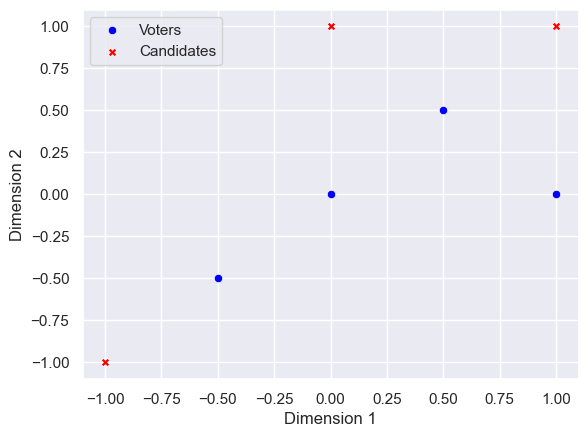

  Voter     0     1     2
-------  ----  ----  ----
      1  -1    -2    -2
      2  -0.5  -0.5  -4.5
      3  -2.5  -4.5  -0.5
      4  -2    -1    -5
+-----+-----+---+---+
|  1  |  1  | 1 | 1 |
+-----+-----+---+---+
|  0  | 0 1 | 2 | 1 |
| 1 2 |  2  | 0 | 0 |
|     |     | 1 | 2 |
+-----+-----+---+---+
  Voter          0          1         2
-------  ---------  ---------  --------
      1  -1.38253   -0.415657  -3.12027
      2  -0.501141  -1.70463   -6.86995
      3  -2.81111   -7.87001   -1.51322
      4  -2.05952   -1.94596   -4.41242
+---+---+---+---+
| 1 | 1 | 1 | 1 |
+---+---+---+---+
| 1 | 0 | 2 | 1 |
| 0 | 1 | 0 | 0 |
| 2 | 2 | 1 | 2 |
+---+---+---+---+


In [63]:

sp = SpatialProfile({0: (0, 1), 1: (1, 1), 2: (-1, -1)}, 
                    {0:(0, 0), 1: (0.5, 0.5), 2: (-0.5, -0.5), 3: (1, 0)})
sp.view()

up = sp.to_utility_profile()
up.display()

up.to_ranking_profile().display()
up2 = sp.to_utility_profile(uncertainty_function=default_uncertainty_fn, batch=True)
up2.display()

up2.to_ranking_profile().to_linear_profile().display()

In [30]:
up = sp.to_utility_profile()
up.display()

  Voter         0          1         2          3
-------  --------  ---------  --------  ---------
      1  -1.99508  -1.52152   -2.15731  -0.541148
      2  -4.26241  -0.480912  -8.28953  -6.5465
      3  -1.02977  -7.3416    -2.06544  -8.43339
